<center><h1>Exploratory Data Analysis</h1></center>

<h2> Importing Libraries</h2>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

<h2>Loading Data</h2>

In [2]:
X_train = pd.read_csv("../Processed Data/All Features/X_train.csv")
X_test = pd.read_csv("../Processed Data/All Features/X_test.csv")
Y_train = pd.read_csv("../Processed Data/All Features/Y_train.csv").squeeze()
Y_test = pd.read_csv("../Processed Data/All Features/Y_test.csv").squeeze()

<h3> Missing Values and Data Types Check</h3>

The data is free from any missing values as they have been checked in other notebook.

In [3]:
non_numeric_cols_X_train = X_train.select_dtypes(include=['object']).columns
print(f"Non numeric columns in X_train: {len(non_numeric_cols_X_train)}")

non_numeric_cols_X_test = X_test.select_dtypes(include=['object']).columns
print(f"Non numeric columns in X_test: {len(non_numeric_cols_X_test)}")

Non numeric columns in X_train: 0
Non numeric columns in X_test: 0


In [4]:
non_numeric_cols_Y_train = Y_train.select_dtypes(include=['object']).columns
print(f"Non numeric columns in Y_train: {len(non_numeric_cols_Y_train)}")

non_numeric_cols_Y_test = Y_test.select_dtypes(include=['object']).columns
print(f"Non numeric columns in Y_train: {len(non_numeric_cols_Y_test)}")

Non numeric columns in Y_train: 1
Non numeric columns in Y_train: 1


It is expected that the Y or target values would have 1 object type, since we have mapped the features based on the activity_code for better interpretability.

<h2>Data Distribution</h2>

Let us see how our data is distributed based on the activities we need to be identifying.

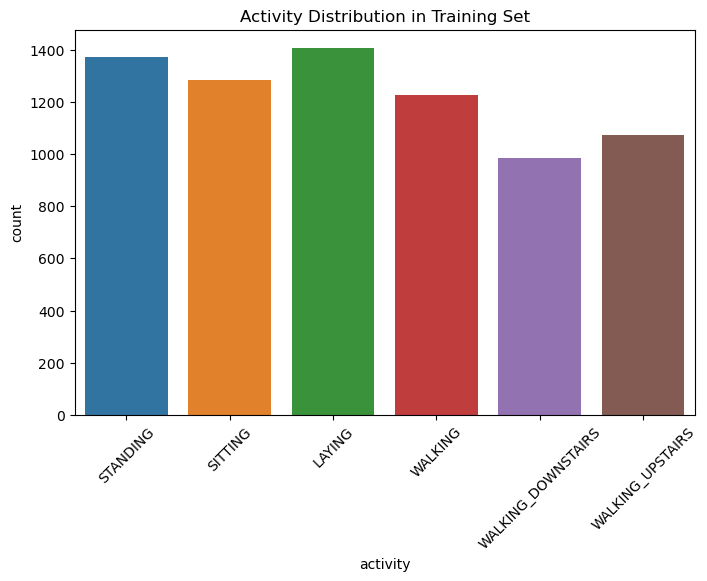

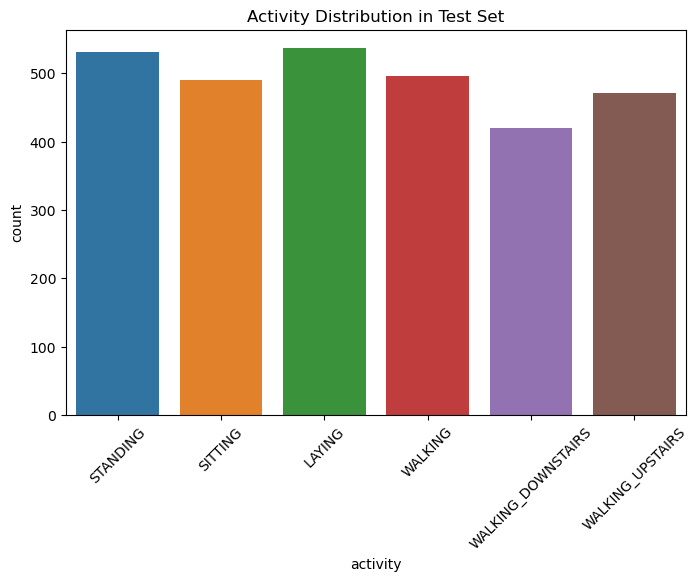

In [5]:
plt.figure(figsize=(8,5))
sns.countplot(x=Y_train["activity"])
plt.title("Activity Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x=Y_test["activity"])
plt.title("Activity Distribution in Test Set")
plt.xticks(rotation=45)
plt.show()

Looks like our data in both training and testing sets are distributed in an equal manner among the activities.

<h2> Feature Variance </h2>

In [6]:
feature_variance = X_train.var()
low_variance_features = feature_variance[feature_variance < 0.01]
print(f"The number of features having a variance less than 0.01 are {len(low_variance_features)} out of {len(X_train.columns)}")

The number of features having a variance less than 0.01 are 37 out of 561


In [7]:
low_variance_features

tBodyAcc-mean()-X_0                     0.004937
tBodyAcc-mean()-Y_1                     0.001665
tBodyAcc-mean()-Z_2                     0.003208
tGravityAcc-std()-X_43                  0.006084
tGravityAcc-std()-Y_44                  0.008366
tGravityAcc-mad()-X_46                  0.005887
tGravityAcc-mad()-Y_47                  0.008180
tGravityAcc-iqr()-X_59                  0.005378
tGravityAcc-iqr()-Y_60                  0.007570
fBodyAcc-bandsEnergy()-25,32_333        0.007780
fBodyAcc-bandsEnergy()-33,40_334        0.007159
fBodyAcc-bandsEnergy()-33,48_340        0.009689
fBodyAcc-bandsEnergy()-25,48_343        0.007824
fBodyAccJerk-bandsEnergy()-57,64_388    0.003367
fBodyAccJerk-bandsEnergy()-57,64_402    0.008928
fBodyAccJerk-bandsEnergy()-25,32_412    0.007487
fBodyAccJerk-bandsEnergy()-33,40_413    0.006514
fBodyAccJerk-bandsEnergy()-33,48_419    0.009088
fBodyAccJerk-bandsEnergy()-25,48_422    0.007637
fBodyGyro-bandsEnergy()-25,32_463       0.007621
fBodyGyro-bandsEnerg

Looks like there are 37 features which have a very low variance.

<b>So what does that mean?</b>

In general, where the variance of features are very low, in this case less than 0.01, they are almost always not providing any useful infromation for the model and it is like having a feature with a constant value, so it is advised for the features to be removed as they keeping draining your computational resources and may hurt your model performance.

<b>Are we going to remove these features?</b>

The answer will be NO, since both the models we will be using are going to be resistant to irrelevant features and they can figure out what the important features on their own.

It is generally advised that for any other models to be used these feature need to be removed.

<h2> Outlier Detection </h2>

It is one of the crucial step that we need to do as a part of our analysis, since their presence skews our models, so understanding outliers and deciding how to handle them is very important.

In [8]:
outlier_counts_per_feature = {}
total_outlier_values = 0

for feature in X_train.columns:
    Q1 = X_train[feature].quantile(0.25)
    Q3 = X_train[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers for this feature
    outliers = X_train[(X_train[feature] < lower_bound) | (X_train[feature] > upper_bound)]
    num_outliers = len(outliers)
    outlier_counts_per_feature[feature] = num_outliers
    total_outlier_values += num_outliers
    
    
outlier_series = pd.Series(outlier_counts_per_feature)

In [9]:
print(f"Total number of individual outlier values found across all features: {total_outlier_values} out of {X_train.shape[0]*(len(X_train.columns))} values")

Total number of individual outlier values found across all features: 163682 out of 4124472 values


It looks like a big number, but around 4 percent of all our values are outliers i.e., 4 in every 100 values.

This is a overall number but let us see the top 5 features with most number of outliers.

In [10]:
print(f"Top 10 features with most outliers are\n\n{outlier_series.sort_values(ascending=False).head(10)}")

Top 10 features with most outliers are

tBodyAccJerk-mean()-X_80      2778
tBodyGyro-mean()-X_120        2369
tBodyGyroJerk-mean()-X_160    2246
tBodyAccJerk-mean()-Y_81      2236
tBodyGyroJerk-mean()-Y_161    2187
tBodyAccJerk-mean()-Z_82      2022
tBodyGyroJerk-mean()-Z_162    1994
tBodyGyro-mean()-Y_121        1801
tBodyAcc-mean()-X_0           1795
tBodyGyro-mean()-Z_122        1610
dtype: int64


If we look at all the features, one thing to be noted is that they are all mean values of some kind of kinetically intense movement, meaning that moment that are sudden. 

So when the moment is sudden, the intensity in which the moment is done differs from person to person and is highly influenced by characterstics like height, weight etc.

So in this case, removing these features does more bad than good.

<h2>Relationships</h2>

<h3> Feature-Target correlation</h3>

<b>Which of the features is the most powerful predictor of the target variable?<b>

We are going to use ANOVA statistic and calculate F-value, P-value for each feature to determine this.

In [11]:
pd.reset_option('display.float_format')

In [12]:
f_values, p_values = f_classif(X_train, Y_train["activity_code"])

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Value': f_values,
    'P_Value': p_values
})

feature_importance_df = feature_importance_df.sort_values('F_Value', ascending=False).reset_index(drop=True)

In [13]:
print("Top 10 Most Predictive Features are \n\n")
print(feature_importance_df.head(10).round())

Top 10 Most Predictive Features are 


                             Feature  F_Value  P_Value
0       fBodyAccJerk-entropy()-X_366  36918.0      0.0
1            tGravityAcc-mean()-X_40  29363.0      0.0
2             tGravityAcc-min()-X_52  28175.0      0.0
3       fBodyAccJerk-entropy()-Y_367  28116.0      0.0
4             tGravityAcc-max()-X_49  26687.0      0.0
5          tGravityAcc-energy()-X_56  25982.0      0.0
6  fBodyBodyAccJerkMag-entropy()_523  23619.0      0.0
7      tBodyAccJerkMag-entropy()_234  23437.0      0.0
8           fBodyAcc-entropy()-X_287  23222.0      0.0
9       tBodyAccJerk-entropy()-X_102  22267.0      0.0


In [14]:
print("Top 10 Least Predictive Features are \n\n")
print(feature_importance_df.tail(10).round(2))

Top 10 Least Predictive Features are 


                                      Feature  F_Value  P_Value
551  angle(tBodyGyroJerkMean,gravityMean)_557     7.43     0.00
552           fBodyBodyAccJerkMag-maxInds_524     5.51     0.00
553           angle(tBodyAccMean,gravity)_554     5.19     0.00
554           tBodyGyroJerk-arCoeff()-X,4_188     3.86     0.00
555                tBodyGyroJerk-mean()-Z_162     1.94     0.08
556                tBodyGyroJerk-mean()-Y_161     1.94     0.09
557  angle(tBodyAccJerkMean),gravityMean)_555     1.39     0.22
558                  tBodyAccJerk-mean()-X_80     0.80     0.55
559                  tBodyAccJerk-mean()-Y_81     0.63     0.68
560                  tBodyAccJerk-mean()-Z_82     0.24     0.94


What we did is ranked our features by their power to distinguish between our activities. 

The F-value tells us how good the feature is at separating the activities. (The higher the better)

The P-value confirms that the F-values are statistically significant or just some random noise (Best if less than 0.05)

<h3>Feature-Feature Correlation</h3>

<b>We just calculated the Feature-Target correlation right? So why should we even worry about the feature-feature correlation?</b>

Let us say we want to take the top 100 best predictors based on ANOVA. But how can we make sure all these features are not providing the same information. This is also called as multi-collinearity.

In [15]:
corr_matrix = X_train.corr()

In [16]:
corr_matrix

tBodyAcc-mean()-X_0  \
tBodyAcc-mean()-X_0                                  1.000000   
tBodyAcc-mean()-Y_1                                  0.148061   
tBodyAcc-mean()-Z_2                                 -0.256952   
tBodyAcc-std()-X_3                                   0.000619   
tBodyAcc-std()-Y_4                                  -0.021903   
...                                                       ...   
angle(tBodyGyroMean,gravityMean)_556                 0.037444   
angle(tBodyGyroJerkMean,gravityMean)_557             0.028844   
angle(X,gravityMean)_558                            -0.035257   
angle(Y,gravityMean)_559                             0.034371   
angle(Z,gravityMean)_560                             0.028242   

                                          tBodyAcc-mean()-Y_1  \
tBodyAcc-mean()-X_0                                  0.148061   
tBodyAcc-mean()-Y_1                                  1.000000   
tBodyAcc-mean()-Z_2                                 -0.078769   
tBodyAcc-std()-X_3                                  -0.045160   
tBodyAcc-std()-Y_4                                  -0.044920   
...                                                       ...   
angle(tBodyGyroMean,gravityMean)_556                 0.017967   
angle(tBodyGyroJerkMean,gravityMean)_557             0.075679   
angle(X,gravityMean)_558                            -0.005309   
angle(Y,gravityMean)_559                             0.001053   
angle(Z,gravityMean)_560                            -0.013903   

                                          tBodyAcc-mean()-Z_2  \
tBodyAcc-mean()-X_0                                 -0.256952   
tBodyAcc-mean()-Y_1                                 -0.078769   
tBodyAcc-mean()-Z_2                                  1.000000   
tBodyAcc-std()-X_3                                  -0.020217   
tBodyAcc-std()-Y_4                                  -0.016641   
...                                                       ...   
angle(tBodyGyroMean,gravityMean)_556                -0.063609   
angle(tBodyGyroJerkMean,gravityMean)_557            -0.034037   
angle(X,gravityMean)_558                             0.008587   
angle(Y,gravityMean)_559                            -0.015288   
angle(Z,gravityMean)_560                            -0.022643   

                                          tBodyAcc-std()-X_3  \
tBodyAcc-mean()-X_0                                 0.000619   
tBodyAcc-mean()-Y_1                                -0.045160   
tBodyAcc-mean()-Z_2                                -0.020217   
tBodyAcc-std()-X_3                                  1.000000   
tBodyAcc-std()-Y_4                                  0.927461   
...                                                      ...   
angle(tBodyGyroMean,gravityMean)_556                0.018985   
angle(tBodyGyroJerkMean,gravityMean)_557           -0.024810   
angle(X,gravityMean)_558                           -0.371653   
angle(Y,gravityMean)_559                            0.471065   
angle(Z,gravityMean)_560                            0.394825   

                                          tBodyAcc-std()-Y_4  \
tBodyAcc-mean()-X_0                                -0.021903   
tBodyAcc-mean()-Y_1                                -0.044920   
tBodyAcc-mean()-Z_2                                -0.016641   
tBodyAcc-std()-X_3                                  0.927461   
tBodyAcc-std()-Y_4                                  1.000000   
...                                                      ...   
angle(tBodyGyroMean,gravityMean)_556               -0.008507   
angle(tBodyGyroJerkMean,gravityMean)_557           -0.014592   
angle(X,gravityMean)_558                           -0.380531   
angle(Y,gravityMean)_559                            0.523600   
angle(Z,gravityMean)_560                            0.433169   

                                          tBodyAcc-std()-Z_5  \
tBodyAcc-mean()-X_0                                -0.044617   
tBodyAcc-mean()-Y_1              

In [17]:
corr_series = corr_matrix.unstack() # Turn matrix into a series
corr_series = corr_series[corr_series.index.get_level_values(0) != corr_series.index.get_level_values(1)] # Remove self-correlation
corr_series = corr_series.sort_values(ascending=False) # Sort by correlation strength
corr_series = corr_series[~corr_series.duplicated()]

In [18]:
corr_series

tBodyAccMag-arCoeff()3_211    tGravityAccMag-arCoeff()3_224      1.000000
fBodyAccJerk-energy()-Z_362   tBodyAccJerk-energy()-Z_98         1.000000
tBodyAccJerk-energy()-Y_97    fBodyAccJerk-energy()-Y_361        1.000000
fBodyAccJerk-energy()-X_360   tBodyAccJerk-energy()-X_96         0.999999
fBodyAcc-energy()-X_281       fBodyAcc-bandsEnergy()-1,24_314    0.999878
                                                                   ...   
tGravityAcc-mean()-Y_41       angle(Y,gravityMean)_559          -0.993502
tGravityAcc-arCoeff()-Z,4_76  tGravityAcc-arCoeff()-Z,3_75      -0.994256
tGravityAcc-arCoeff()-Z,3_75  tGravityAcc-arCoeff()-Z,2_74      -0.994684
angle(Z,gravityMean)_560      tGravityAcc-mean()-Z_42           -0.995070
tGravityAcc-arCoeff()-Z,1_73  tGravityAcc-arCoeff()-Z,2_74      -0.995297
Length: 145570, dtype: float64

In [19]:
top_corr_pairs = corr_series.head(10)
for index, value in top_corr_pairs.items():
    feat1, feat2 = index
    print(f"  {feat1} \n  {feat2} \n  Correlation: {value:.4f}\n")

  tBodyAccMag-arCoeff()3_211 
  tGravityAccMag-arCoeff()3_224 
  Correlation: 1.0000

  fBodyAccJerk-energy()-Z_362 
  tBodyAccJerk-energy()-Z_98 
  Correlation: 1.0000

  tBodyAccJerk-energy()-Y_97 
  fBodyAccJerk-energy()-Y_361 
  Correlation: 1.0000

  fBodyAccJerk-energy()-X_360 
  tBodyAccJerk-energy()-X_96 
  Correlation: 1.0000

  fBodyAcc-energy()-X_281 
  fBodyAcc-bandsEnergy()-1,24_314 
  Correlation: 0.9999

  fBodyGyro-bandsEnergy()-1,24_472 
  fBodyGyro-energy()-X_439 
  Correlation: 0.9998

  fBodyAcc-bandsEnergy()-1,24_328 
  fBodyAcc-energy()-Y_282 
  Correlation: 0.9997

  tBodyAccJerk-sma()_95 
  tBodyAccJerkMag-sma()_231 
  Correlation: 0.9997

  fBodyAcc-energy()-X_281 
  tBodyAcc-energy()-X_16 
  Correlation: 0.9996

  fBodyGyro-energy()-Z_441 
  fBodyGyro-bandsEnergy()-1,24_500 
  Correlation: 0.9995



If we see the top 10 highly corelated features, one common thing we can observe is that both the highly related features are same but their metrics and magnitude are different.

This means that including only one feature out of the two in our feature set keeps our model light without losing meaningful information. This reduces redundancy.

In [20]:
n_top_features = int(0.40 * len(feature_importance_df))
top_anova_features = feature_importance_df['Feature'].head(n_top_features).tolist()
print(f"Number of top 40% ANOVA features: {len(top_anova_features)}")

X_train_anova = X_train[top_anova_features].copy()

corr_matrix_anova = X_train_anova.corr().abs()

threshold = 0.95
features_to_remove = set()

all_features = set(top_anova_features) # Looks unused check and remove

for feat1 in top_anova_features:
    if feat1 in features_to_remove:
        continue
        
    highly_correlated = []
    for feat2 in top_anova_features:
        if feat1 != feat2 and feat2 not in features_to_remove:
            corr_value = corr_matrix_anova.loc[feat1, feat2]
            if corr_value > threshold:
                highly_correlated.append(feat2)
    
    for feat2 in highly_correlated:
        f1 = feature_importance_df[feature_importance_df['Feature'] == feat1]['F_Value'].values[0]
        f2 = feature_importance_df[feature_importance_df['Feature'] == feat2]['F_Value'].values[0]
        
        if f1 < f2:
            features_to_remove.add(feat1)
            break
        else:
            features_to_remove.add(feat2)

print(f"Number of features to remove due to high correlation: {len(features_to_remove)}")

final_anova_features = [feat for feat in top_anova_features if feat not in features_to_remove]
X_train_anova_filtered = X_train[final_anova_features].copy()
X_test_anova_filtered = X_test[final_anova_features].copy()

print(f"Final number of features in Set D: {len(final_anova_features)}")

X_train_anova_filtered.to_csv('../Processed Data/ANOVA hybrid set/X_train_anova_filtered_40.csv', index=False)
X_test_anova_filtered.to_csv('../Processed Data/ANOVA hybrid set/X_test_anova_filtered_40.csv', index=False)

Number of top 40% ANOVA features: 224
Number of features to remove due to high correlation: 169
Final number of features in Set D: 55


Here we are creating a new dataset by taking the top 50 percent of the features based on ANOVA F-test scores and then filtering them such that only one of two highly correlated features if exists in the already extracted set.

<h2>Feature Understanding</h2>

So we know some of the best features based on the F-value and P-value. Why are they the best? Is it based on a single activity or multiple?

In [21]:
top_4_features = feature_importance_df['Feature'].head(4).tolist()

print("Top 4 features to analyze:")
for i, feat in enumerate(top_4_features, 1):
    print(f"  {i}. {feat}")

Top 4 features to analyze:
  1. fBodyAccJerk-entropy()-X_366
  2. tGravityAcc-mean()-X_40
  3. tGravityAcc-min()-X_52
  4. fBodyAccJerk-entropy()-Y_367


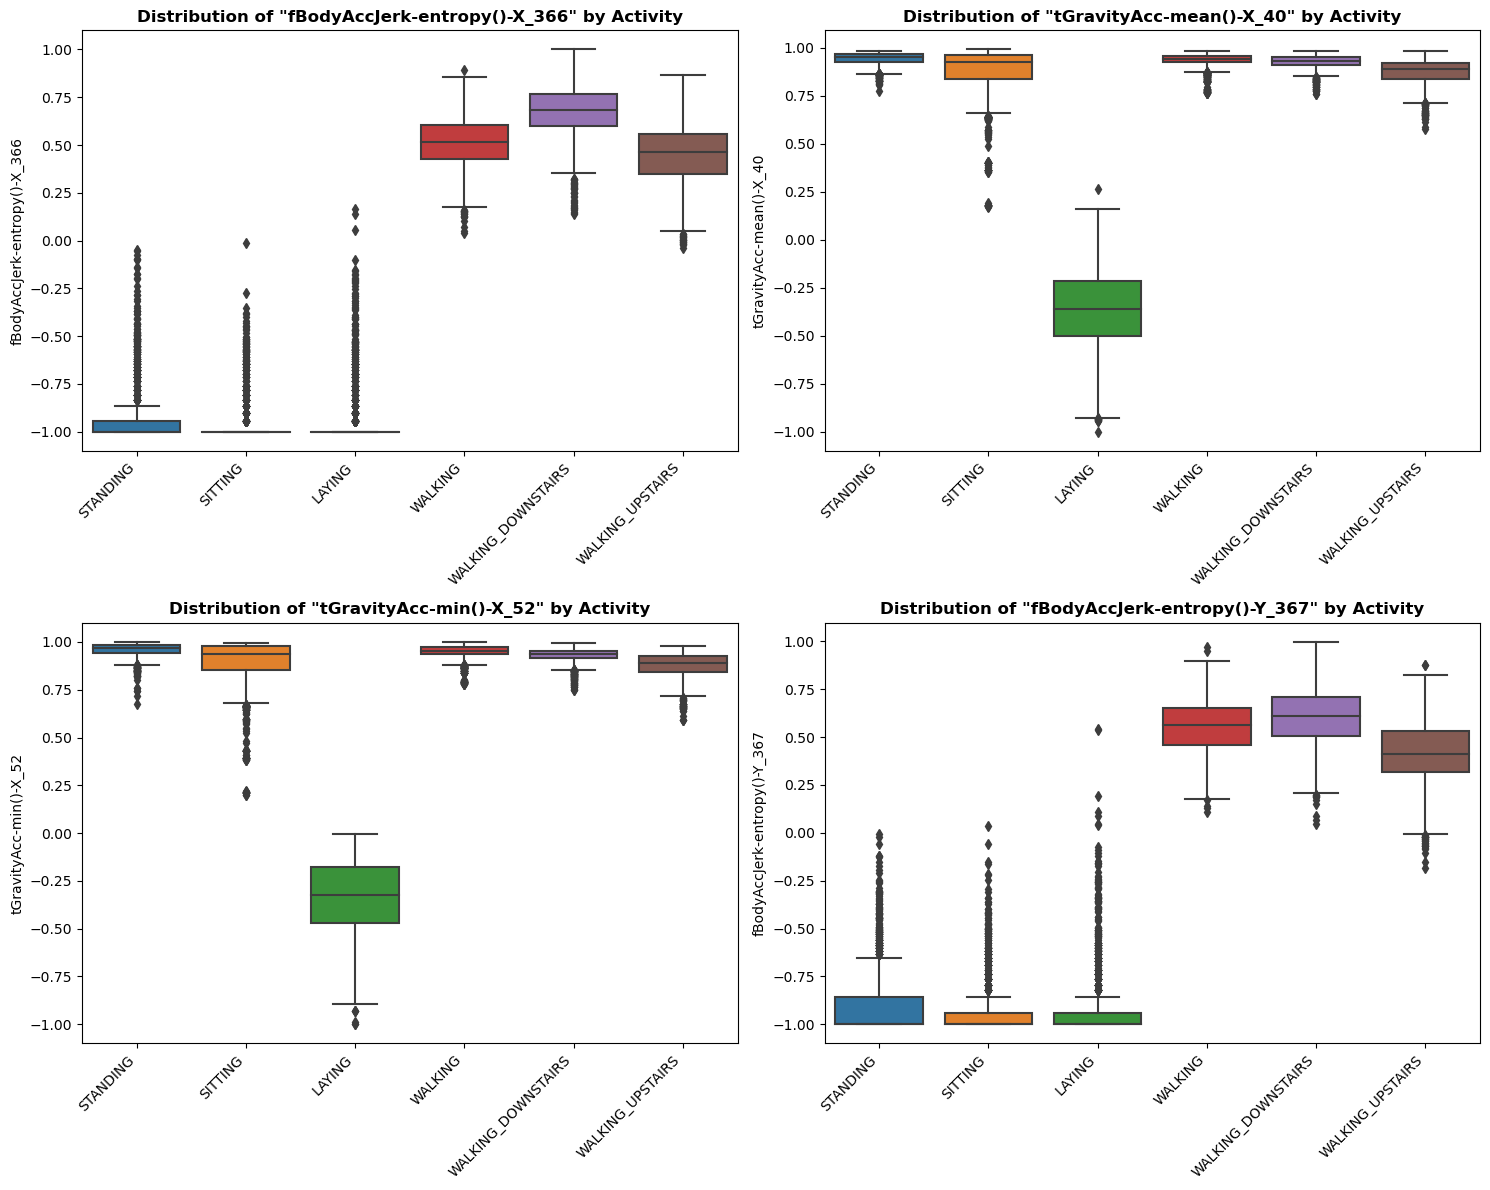

In [22]:
plot_df = X_train[top_4_features].copy()
plot_df['Activity'] = Y_train["activity"] 

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel() 

for i, feature in enumerate(top_4_features):
    sns.boxplot(data=plot_df, x='Activity', y=feature, ax=axes[i])
    axes[i].set_title(f'Distribution of "{feature}" by Activity', fontweight='bold')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

So if we clearly observe all the 4 features, the <b>fBodyAccjerk feature is good at differentiating static and dynamic activities</b>, while the <b>tGravityAcc feature is good at differentiating laying vs other postures</b>.

<h2> Principal Component Analysis</h2>

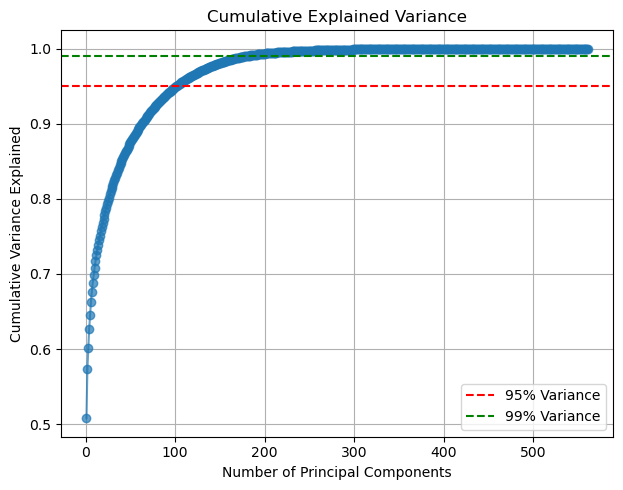

Total number of original features: 561
Number of components to explain 95% of variance: 102
Number of components to explain 99% of variance: 179
First component alone explains 50.78% of the variance.


In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA() 
pca.fit(X_train_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', alpha=0.7)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

print(f"Total number of original features: {X_train.shape[1]}")
print(f"Number of components to explain 95% of variance: {n_components_95}")
print(f"Number of components to explain 99% of variance: {n_components_99}")
print(f"First component alone explains {pca.explained_variance_ratio_[0]*100:.2f}% of the variance.")

The main point here to understand is that a single component does not mean a single feature. A single component is a combination of one or more features.

Here as we can see that 99% of variance can be explained by just 179 components, meaning that 179 combinations of our 561 features are good enough to retain 99% of the information that we have with our original set of features.

If we want to use the principal components derived from PCA, we can transform the training and testing data based on these components and train our model.

In [24]:
pca_95 = PCA(n_components=0.95, random_state=42)  
X_train_pca_95 = pca_95.fit_transform(X_train_scaled)
X_test_pca_95 = pca_95.transform(scaler.transform(X_test))  

pca_99 = PCA(n_components=0.99, random_state=42)  
X_train_pca_99 = pca_99.fit_transform(X_train_scaled)
X_test_pca_99 = pca_99.transform(scaler.transform(X_test))

columns_95 = [f'PC_{i+1}' for i in range(X_train_pca_95.shape[1])]
columns_99 = [f'PC_{i+1}' for i in range(X_train_pca_99.shape[1])]

X_train_pca_95_df = pd.DataFrame(X_train_pca_95, columns=columns_95, index=X_train.index)
X_test_pca_95_df = pd.DataFrame(X_test_pca_95, columns=columns_95, index=X_test.index)

X_train_pca_99_df = pd.DataFrame(X_train_pca_99, columns=columns_99, index=X_train.index)
X_test_pca_99_df = pd.DataFrame(X_test_pca_99, columns=columns_99, index=X_test.index)

X_train_pca_95_df.to_csv('../Processed Data/X_train_pca_95.csv', index=False)
X_test_pca_95_df.to_csv('../Processed Data/X_test_pca_95.csv', index=False)

X_train_pca_99_df.to_csv('../Processed Data/X_train_pca_99.csv', index=False) 
X_test_pca_99_df.to_csv('../Processed Data/X_test_pca_99.csv', index=False)

print("✅ PCA feature sets created and exported successfully!")
print(f"X_train_pca_95 shape: {X_train_pca_95.shape}")
print(f"X_test_pca_95 shape: {X_test_pca_95.shape}")
print(f"X_train_pca_99 shape: {X_train_pca_99.shape}")
print(f"X_test_pca_99 shape: {X_test_pca_99.shape}")

✅ PCA feature sets created and exported successfully!
X_train_pca_95 shape: (7352, 102)
X_test_pca_95 shape: (2947, 102)
X_train_pca_99 shape: (7352, 179)
X_test_pca_99 shape: (2947, 179)


We want to train both our models on either with PCA components that explain 95% or 99% variance or both. So we have made both datasets and exported them to use for model training.

<h2>Clustered Visualization of our Data</h2>

Based on the features we have, we will get to see if our data is separable, if yes we can see how clusters for each activity separate from each other.

In [27]:
print("Computing 3D t-SNE transformation...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
X_train_tsne_3d = tsne_3d.fit_transform(X_train)

# Then run your plotting code
print(f"Creating interactive 3D t-SNE on FULL training set...")
tsne_3d_df = pd.DataFrame({
    't-SNE Component 1': X_train_tsne_3d[:, 0],
    't-SNE Component 2': X_train_tsne_3d[:, 1],
    't-SNE Component 3': X_train_tsne_3d[:, 2],
    'Activity': Y_train["activity"]
})


Computing 3D t-SNE transformation...


/Users/trinadhatmuri/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/trinadhatmuri/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Creating interactive 3D t-SNE on FULL training set...


In [28]:
print(f"Creating interactive 3D t-SNE on FULL training set...")

tsne_3d_df = pd.DataFrame({
    't-SNE Component 1': X_train_tsne_3d[:, 0],
    't-SNE Component 2': X_train_tsne_3d[:, 1],
    't-SNE Component 3': X_train_tsne_3d[:, 2],
    'Activity': Y_train["activity"]
})

fig = px.scatter_3d(tsne_3d_df, 
                    x='t-SNE Component 1', 
                    y='t-SNE Component 2', 
                    z='t-SNE Component 3',
                    color='Activity',
                    title='Interactive 3D t-SNE Visualization of Human Activity Data (Full Training Set)',
                    opacity=0.7,
                    height=800)

fig.update_traces(marker=dict(size=3))  
fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))

print("Displaying interactive plot...")
print("→ Use your mouse to rotate: Click and drag")
print("→ Zoom: Scroll wheel")
print("→ Pan: Hold shift and drag")
print("→ Reset view: Double-click")

fig.show()

Creating interactive 3D t-SNE on FULL training set...
Displaying interactive plot...
→ Use your mouse to rotate: Click and drag
→ Zoom: Scroll wheel
→ Pan: Hold shift and drag
→ Reset view: Double-click


On observing the 3-D graph the following observations are made.

<ul>
    <li>There is a clear overlap between similar activities. For example sitting and standing are idle activities and we can see the the Red and Thick Blue (I don't know what they call this color :(), which are probably the hardest activities to distinguish.</li>
    <li> Although the Walking, Walking Upstairs and Walking Downstairs are similar activities they are clearly separable for the most part. If we observe they have mini clusters rather than a single big cluster especially Walking (purple) and Walking Upstairs (Sky Blue). </li>
    <li> The easiest and most accurately separable activity is Laying, since most of its points are seen in a single big cluster which can be separated from every other activity. </li>
</ul>